In [ ]:
### This notebook is a tutorial on making hybrid gravitational waveforms. Here we will walk through the process
### using hybridmodules.py included https://github.com/eflynn67/HybridTools. Necessary functions from hybridmodules.py
### will be included in this notebook so that it is self-contained but you can import hybridmodules.py below by 
###using: import hybridmodules as hy
### This notebook uses Pycbc. Make sure you have it installed before you begin.

In [1]:
### first import all the necessary modules
#import hybridmodules as hy ## This hybridmodules.py script must be in the same directory as this notebook with __int__.py
import os
import numpy as np
import h5py
import scipy as sci
import lal
import lalsimulation as lalsim
from pycbc import pnutils
import pycbc
from pycbc.types import TimeSeries
from pycbc.waveform import utils as wfutils
from pycbc.waveform import get_td_waveform,td_approximants
import romspline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
### hybrid functions from hybridmodules.py. For more details about these functions, have a look at hybridmodules.py    
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx],idx
def getApprox(type,name,m1=10.0,m2=10.0,f_ref=0.0,f_low=50.0,distance=1,delta_t=1.0/4096.0,s1x=0,s1y=0,s1z=0,s2x=0,s2y=0,s2z=0,inclination=0,tidal1=0,tidal2=0):
    if type == 'pycbc':
        hp, hc = get_td_waveform(approximant = name, mass1=m1,
                                                mass2=m2,
                                                f_lower=f_low,
                                                f_ref = f_ref,
                                                distance= distance,
                                                delta_t= delta_t,
                                                spin1x = s1x,
                                                spin1y = s1y,
                                                spin1z = s1z,
                                                spin2x = s2x,
                                                spin2y = s2y,
                                                spin2z = s2z,
                                                lambda1 = tidal1,
                                                lambda2 = tidal2,
                                                inclination= inclination)

        new_hp = np.array(hp)
        new_hc = np.array(hc)
        h = new_hp + new_hc*1j
        times = np.array(hp.sample_times)
        shift_times = times - times[0]
        return (shift_times,h)
    elif type == 'laltd':
        mpc = 1.0e6*lal.PC_SI
        m1 = m1*lal.MSUN_SI
        m2 = m2*lal.MSUN_SI
        distance = distance*mpc
        tidal_params = lal.CreateDict()
        lalsim.SimInspiralWaveformParamsInsertTidalLambda1(tidal_params,tidal1)
        lalsim.SimInspiralWaveformParamsInsertTidalLambda2(tidal_params,tidal2)
        hp, hc = lalsim.SimInspiralTD(m1, m2,s1x,s1y,s1z,s2x,s2y,s2z,
                                                  distance, inclination, phiRef, 0.,0.,0.,
                                                  delta_t, f_low, f_ref,tidal_params,lalsim.SimInspiralGetApproximantFromString(name))
        times = np.arange(len(hp.data.data))*delta_t + hp.epoch
        shift_times = times - times[0]
        h = np.array(hp.data.data + 1j*hc.data.data)
        return(shift_times,h)
    else:
        print 'Specify pycbc or laltd for approx type'
def m_phase_from_polarizations(hp,hc,remove_start_phase=True):
        p_wrapped = np.arctan2(hp,hc)
        p = np.unwrap(p_wrapped)
        if remove_start_phase:
                p += -p[0]
        return np.abs(p)
def m_frequency_from_polarizations(hp,hc,delta_t):
        phase = m_phase_from_polarizations(hp,hc)
        freq = np.diff(phase)/(2.0*np.pi*delta_t)
        return freq
def hybridize(h1,h1_ts,h2,h2_ts,match_i,match_f,delta_t=1/4096.0,M=200,info=0):
        h2_seg = h2[match_i:match_f]
        z = sci.signal.fftconvolve(h1,np.conj(h2_seg[::-1]))
        abs_z = np.abs(z)
        w = np.argmax(abs_z) - len(h2_seg) + 1
        delta_w = w + len(h2_seg)
        h2_norm = np.linalg.norm(h2_seg)
        h1_norm = np.linalg.norm(h1[w:delta_w])
        norm_z = abs_z/(h1_norm*h2_norm)
        phi = np.angle(z[np.argmax(abs_z)])
        h2_phase_shift = np.exp(1j*phi)*h2
        shift_time  = (w - match_i)*delta_t
        h2_tc = h2_ts - h2_ts[0] + shift_time
        off_len = (M-1)/2 + 1
        on_len = (M+1)/2
        window = sci.signal.hann(M)
        ##Initialize off and on arrays
        off_hp = np.zeros(off_len)
        on_hp = np.zeros(on_len)
        off_hc = np.zeros(off_len)
        on_hc = np.zeros(on_len)
        ##Bounds for windowing functions
        lb= w
        mid=off_len + w
        ub = M-1 + w
        ##multiply each off and on section by appropriate window section
        for i in range(on_len):
                on_hp[i] = np.real(h2_phase_shift[match_i+i])*window[i]
        for i in range(off_len):
                off_hp[i] = np.real(h1[w+i])*window[i+off_len-1]
        for i in range(on_len):
                on_hc[i] = np.imag(h2_phase_shift[match_i+i])*window[i]
        for i in range(off_len):
                off_hc[i] = np.imag(h1[w+i]*window[i+off_len-1])
         ##Next add the on and off sections together
        mix_hp = on_hp + off_hp
        mix_hc = on_hc + off_hc
        h1_hp_split = np.real(h1[:w])
        h1_hc_split = np.imag(h1[:w])
        h1_ts_split = h1_ts[:w]
        hybrid_t = np.concatenate((np.real(h1_ts_split),np.real(h2_tc[match_i:])), axis =0)
        hybrid_hp = np.concatenate((h1_hp_split,mix_hp,np.real(h2_phase_shift[match_i+off_len:])),axis = 0)
        hybrid_hc = np.concatenate((h1_hc_split,mix_hc,np.imag(h2_phase_shift[match_i+off_len:])),axis =0)
        hybrid = (hybrid_t, hybrid_hp, hybrid_hc)
        freq = m_frequency_from_polarizations(hybrid_hp,hybrid_hc,delta_t=delta_t)
        hh_freq = freq[w]
        if info == 0:
                return hybrid
        if info == 1:
                return(np.max(norm_z),w,phi,h2_phase_shift,h2_tc,hybrid,h2_tc[0],hh_freq)
        else:
                return 'use info = 0 or 1'
def find_junk(filepath,total_mass,inclination,distance,coa_phase,upper_f_bound,delta_t,f_shift=0,cycle_number=4.0,):
    f = h5py.File(filepath, 'r')
    database_key = f.attrs['name']
    num_start_freq = f.attrs['f_lower_at_1MSUN'] + 1.0 ### Given numerical starting frequency. The +1.0 is to avoid input error
    ### import waveform
    hp, hc = get_td_waveform(approximant='NR_hdf5',
                                 numrel_data=filepath,
                                 mass1 = f.attrs['mass1']*total_mass,
                                 mass2 = f.attrs['mass2']*total_mass,
                                 spin1x = f.attrs['spin1x'],
                                 spin1y = f.attrs['spin1y'],
                                 spin1z = f.attrs['spin1z'],
                                 spin2x = f.attrs['spin2x'],
                                 spin2y = f.attrs['spin2y'],
                                 spin2z = f.attrs['spin2z'],
                                 delta_t=delta_t,
                                 f_lower = num_start_freq,
                                 inclination = inclination,
                                 distance = distance,
                                 coa_phase = coa_phase,
                                 mode_array=[[2,2]])
    f.close()
    ### cast h as a complex number 
    h = np.array(hp) + np.array(hc)*1j
    ### get sample times in a numpy array
    ht = np.array(hp.sample_times)
    ### get instantaneous frequency series d \phi/ dt
    f_series = m_frequency_from_polarizations(np.real(h),np.imag(h),delta_t)
    ### shift the time series so that it starts at t=0 instead of at a negative number 
    h_tc = ht - ht[0]
    ### selected_starting_frequency is the variable that is going to be itertated to find a starting frequency with reduced junk in the beginning  
    selected_starting_frequency = num_start_freq + f_shift
    t_junk_window = cycle_number/selected_starting_frequency ### approximate time length that includes junk radiation 
    ### get time from the numerical time series that is closest to t_junk_window at which
    time_nearest = find_nearest(h_tc,t_junk_window)
    ### get frequency at time_nearest
    f_junk_series = f_series[:time_nearest[1]]
    ### now reverse the window we have chosen to include junk radiation. The reason we do this is so that the largest oscillations due to junk radiation are now on the very end of
    ### the window. 
    rev_f_junk_series = f_junk_series[::-1]
    ### Now here is where the method can break down. We look for the largest junk radiation oscillation and define an "initial region" on the now reveresed frequnecy series. So at 
    ### this point, we have smaller region that only goes up to the index of the largest oscillation. We are now going to increment the selected_starting frequency so that the 
    ### distance between selected_starting frequency and the value in the initial region is minimized.
    max_index = np.argmax(rev_f_junk_series)
    initial_region = rev_f_junk_series[:max_index]
    first_f_start = find_nearest(initial_region,selected_starting_frequency)
    dist_f = abs(first_f_start[0] - selected_starting_frequency)
    ### we say the starting frequency in the good region cannot be farther than an upper_f_bound in Hz set by the user away from the real starting freq. So what this while is doing
    ### is iterating the selected starting frequnecy until it is within some distance away from the theory starting frequency.
    while dist_f > upper_f_bound:
        f_shift+=1 ## shift it up by one then recalculate dist_f
        selected_starting_frequency = num_start_freq + f_shift
        t_junk_window = cycle_number/selected_starting_frequency
        time_nearest = find_nearest(h_tc,t_junk_window)
        f_junk_series = f_series[:time_nearest[1]]

        rev_f_junk_series = f_junk_series[::-1]
        max_index = np.argmax(rev_f_junk_series)
        ### now recut initial region so that the window doesn't include junk raditation.
        initial_region = rev_f_junk_series[:max_index]
        first_f_start = find_nearest(initial_region,selected_starting_frequency)
        dist_f = abs(first_f_start[0] - selected_starting_frequency)
    ### once the distance is minimized, we now cut off the beginning amount of the simulation set by max_index.
    shift = len(f_junk_series) - first_f_start[1]
    new_time_shift = h_tc[shift:] - h_tc[shift:][0]
    new_h_shift = h[shift:]
    new_f_series = f_series[shift:]
    ### returns the new cut waveform along with the new starting frequency, the time and frequency shifts required to remove junk
    return ((new_time_shift,new_h_shift,new_f_series),(first_f_start[0],f_shift,shift,database_key))
def treat_junk(filepaths,total_mass,inclination,distance,coa_phase,upper_f_bound,f_shift,delta_t=1.0/4096.0,cycle_number=4.0,):
    check = 0
    wavedata = []
    metadata = []
    f_shifts = []
    while check == 0:
        for name in filepaths:
            junk_removed = find_junk(name,total_mass,inclination,distance,coa_phase,upper_f_bound,delta_t,f_shift,cycle_number=4.0)
            wavedata.append(junk_removed[0])
            metadata.append(junk_removed[1])
        for i,val in enumerate(metadata):
            f_shifts.append(metadata[i][1])
        max_f = np.amax(f_shifts)

        for i,val in enumerate(f_shifts):
            if val != max_f:
                junk_removed = find_junk(filepaths[i],total_mass,inclination,distance,coa_phase,upper_f_bound,delta_t,f_shift=max_f,cycle_number=4.0)
                wavedata[i] = junk_removed[0]
                metadata[i] = junk_removed[1]
        check += 1
    return wavedata,metadata

In [ ]:
### Print out all available time domain approximates from pycbc
for i in td_approximants():
    print i

In [3]:
# Set sample rate for waveforms. Typically a large sample rate is need for EOB and IMRPhenom waves.
sample_rate = 4096.0*16.0
delta_t = 1.0/sample_rate
Sph_Harm = 0.6307831305 ### 2-2 spin weighted spherical harmonic. We are only concerned about the 2-2 here.
solar_mass_mpc = lal.MRSUN_SI / (10**6 * lal.PC_SI)

In [4]:
# Path to numerical waveform. We assume the format set by Derek 
sim_name = '/home/ericf2/Simulations/BNS/CoRe/unsorted/CoRe_BAM_0103_R01_r01000.h5' 

In [5]:
#### read in h5 file and get numerical parameters
#### For BH_NS or BNS, if tidal coeff. are not included, use lalsim_get_ns_params to calculation them
#### Note: sometimes when the spins are small, pycbc returns an error. If that happens just set spins to 0.0 manually
#### or floor the number.
num = h5py.File(sim_name, 'r')
### the for loop below just lists all of the attributes associated with the simulation given by sim_name
#for item in num.attrs.keys():
#    print item + ":", num.attrs[item]
hybrid_type = num.attrs['type']
grav_m1 = num.attrs['mass1-msol']
grav_m2 = num.attrs['mass2-msol']
bary_m1 = num.attrs['baryonic-mass1-msol']
bary_m2 = num.attrs['baryonic-mass2-msol']
m1 = num.attrs['mass1'] # m1 and m1 are masses such that m1 + m2 = 1 
m2 = num.attrs['mass2']
name = num.attrs['name']
total_mass = grav_m1 + grav_m2
s1x = num.attrs['spin1x']
s1y = num.attrs['spin1y']
s1z = num.attrs['spin1z']
s2x = num.attrs['spin2x']
s2y = num.attrs['spin2y']
s2z = num.attrs['spin2z']
LNhatx = num.attrs['LNhatx']
LNhaty = num.attrs['LNhaty']
LNhatz = num.attrs['LNhatz']
n_hatx = num.attrs['nhatx']
n_haty = num.attrs['nhaty']
n_hatz = num.attrs['nhatz']
lambda_1 = num.attrs['tidal-lambda1-l2'] ## 2-2 mode tidal parameter
lambda_2 = num.attrs['tidal-lambda2-l2']
distance = 75.4 ## observer distance in Mpc
inclination = 0.0
f_low_num = num.attrs['f_lower_at_1MSUN'] + 1.0
num.close()
f_low_approx = 80 ## starting frequency of the approximant you want to hybridize


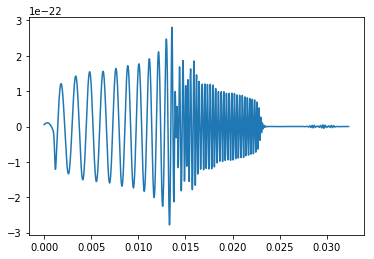

In [6]:
### Using get_td_waveform, generate the numerical waveform 
hp_num,hc_num = get_td_waveform(approximant='NR_hdf5',numrel_data=sim_name,mass1=grav_m1,
                                                                      mass2=grav_m2,
                                                                      spin1z=s1z,spin1x=s1x,spin1y=s1y,
                                                                      spin2z=s2z,spin2x=s2x,spin2y=s2y,
                                                                      tidal1=lambda_1,tidal2=lambda_2,
                                                                      delta_t=delta_t,distance=distance,
                                                                      f_lower=f_low_num,
                                                                      inclination=inclination)
# cast the numerical as a complex number. We need to use numpy arrays here since the hybridmodules.py functions uses numpy
h_num = np.array(hp_num + 1j*hc_num)
# generate time series as a numpy array
h_num_t = np.array(hp_num.sample_times)
#shift the time series so that the waveform starts at t=0
h_num_ts = h_num_t - h_num_t[0]
plt.plot(h_num_ts,np.real(h_num))
plt.show()

[0.00000000e+00 1.52587891e-05 3.05175781e-05 ... 3.01055908e-02
 3.01208496e-02 3.01361084e-02]


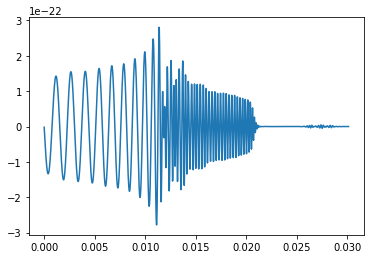

In [7]:
## Every numerical simulation typically has some junk radiation or a section that is non-physical in the beginning of the waveform
## we can systematically remove these sections by using the treat_junk() function defined in hybridmodules.py 
## or in the beginning of this tutorial notebook.
### To treat the junk, just give it the path names and the physical parameters and the function will attempt to remove
### unphysical data. NOTE: sometimes this function fails for simulations with large amounts of junk radiation

sim_names = [sim_name] # treat_junk() takes in sets of numerical waveforms so the sim_name needs to be in a list
coa_phase = 0.0
f_shift = 1.0 ## initial shift from starting frequency given by numerical simulation
upper_f_bound = 3.0 # the maximum distance between the given starting frequency and the new beginning frequency.
treated_numerical = treat_junk(sim_names,total_mass,inclination,distance,coa_phase,upper_f_bound,f_shift,delta_t=delta_t,cycle_number=1.0)
#treat_junk returns a tuple
numerical = treated_numerical[0] # first column returns the treated waveform 
#numerical_metadata = treated_numerical[1] # second column returns the meta data for the corresponding simulation
### since we already have the metadata for the simulation, we will not use the numerical_metadata variable
### The reason the function outputs the metadata is so we can treat multiple simulations and resolutions simultaneously.
treated_time = numerical[0][0] # the structure is numerical[index for nth waveform][index for time,strain, or freq]
print treated_time
treated_strain = numerical[0][1]
plt.plot(treated_time,np.real(treated_strain))
plt.show()

In [8]:
##### HYBRID CONSTRUCTION PARAMETERS#####
#########################################
# Below are the parameters necessary to construct a hybrid 
# First, specify the waveform model available from pycbc. you can see which are avialable by printing td_approximants()
approx ='TaylorT4' # Must be a string
ip2 = 0 #beginning window point index
fp2 = 700 # ending window point index

    

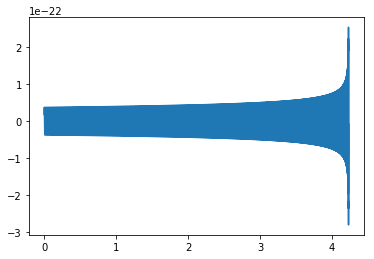

In [9]:
### we use getApprox here. This function is just a condensed get_td_waveform with the ability to generate td waveforms
### directly from lalsim.
PN_model = getApprox('pycbc',approx,m1=grav_m1,m2=grav_m2,f_ref=0.0,f_low=f_low_approx,distance=distance,delta_t=delta_t,s1x=s1x,s1y=s1y,s1z=s1z,s2x=s2x,s2y=s2y,s2z=s2z,inclination=inclination,tidal1=lambda_1,tidal2=lambda_2)
h_approx = PN_model[1] ### already in complex form
h_approx_ts = PN_model[0] ### already time shifted
plt.plot(h_approx_ts,np.real(h_approx))
plt.show()

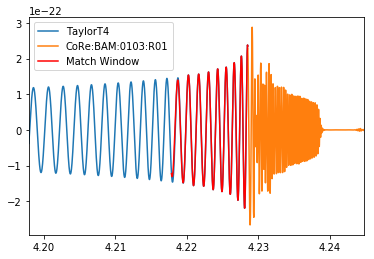

Match =  0.9921754169008693


In [10]:
### this returns an array of the form (np.max(norm_z),w,phi,h2_phase_shift,h2_tc,hybrid,h2_tc[0],hh_freq)
### match = np.max(norm_z)
### shift_index = w 
### phase_angle = phi 
### h2_phase_shift = h2 polarizations with e^(i*phi) phase shift
### time_shifted sample times = h2_tc 
### new hybrid wave = hybrid. this is of the form (timeseries,hp,hc)
### beginning of shifted timeseries = h2_tc[0]
### hybridization frequency (place where numerical starts) = hh_freq 
hybrid = hybridize(h_approx,h_approx_ts,treated_strain,treated_time,
                      match_i=ip2,match_f=fp2,delta_t=delta_t,M=300,info=1)
w = hybrid[1] ## the index point the waveforms are glued together
plt.plot(hybrid[5][0][:w+fp2],hybrid[5][1][:w+fp2],label=approx)
plt.plot(hybrid[5][0][w+fp2:],hybrid[5][1][w+fp2:],label=name)
plt.plot(hybrid[4][ip2:fp2],np.real(hybrid[3][ip2:fp2]),color='red',label='Match Window')
merger_time_index = np.argmax(hybrid[5][1]) 
merge_t = hybrid[5][0][merger_time_index]
plt.xlim([merge_t-sample_rate*delta_t/32,merge_t+sample_rate*delta_t/64])
plt.legend()
plt.show()
match = hybrid[0]
print 'Match = ', hybrid[0]

In [11]:
### Now write the hybrid waveform to hdf5 file. This is written in a summed spherical harmonic format since Pycbc reads 
### in all the (l,m) modes.
#### Below is an example of writing a hybrid in format = 1 similar to what Derek has in his formatting script. These 
#### waveforms can be generated in pycbc using the numerical framework. You have to be careful of the spin weighted 
#### spherical harmonic factors that are used to generate thewaveform. When the hybrid is generated, you need to divide
#### out the spherical harmonic factors. See arxiv 1703.01076 for details.
#### The default hybrid organization here is hybrid type/simulation_name/approximate/...h5

###### NOTE: metadata conventions are subject to change. The naming conventions here are likely to change since I don't 
###### have a clue what the accepted conventions are for hybrid waves.

path_name_data = 'HybridAnnex/'+type+'/'+sim_name+'/'+approx+'/'
hybrid_name = 'hybrid_example.h5'
if not os.path.exists(os.path.dirname(path_name_data)):
                            try:
                                os.makedirs(os.path.dirname(path_name_data))
                            except OSError as exc:
                                if exc.errno != errno.EEXIST:
                                    raise

with h5py.File(path_name_data+hybrid_name,'w') as fd:
    mchirp, eta = pnutils.mass1_mass2_to_mchirp_eta(grav_m1, grav_m2)
    fd.attrs['type'] = 'Hybrid:%s'%type
    fd.attrs['hgroup'] = 'Read_CSUF'
    fd.attrs['Format'] = 1
    fd.attrs['Lmax'] = 2
    fd.attrs['approx'] = approx
    fd.attrs['sim_name'] = name
    fd.attrs['f_lower_at_1MSUN'] = f_low_num
    fd.attrs['eta'] = eta
    fd.attrs['spin1x'] = s1x
    fd.attrs['spin1y'] = s1y
    fd.attrs['spin1z'] = s1z
    fd.attrs['spin2x'] = s2x
    fd.attrs['spin2y'] = s2y
    fd.attrs['spin2z'] = s2z
    fd.attrs['LNhatx'] = LNhatx
    fd.attrs['LNhaty'] = LNhaty
    fd.attrs['LNhatz'] = LNhatz
    fd.attrs['nhatx'] = n_hatx
    fd.attrs['nhaty'] = n_haty
    fd.attrs['nhatz'] = n_hatz
    fd.attrs['mass1'] = m1
    fd.attrs['mass2'] = m2
    fd.attrs['grav_mass1'] = grav_m1
    fd.attrs['grav_mass2'] = grav_m2
    fd.attrs['baryon_mass1'] = bary_m1
    fd.attrs['baryon_mass2'] = bary_m2
    fd.attrs['lambda1'] = lambda_1
    fd.attrs['lambda2'] = lambda_2
    #fd.attrs['hybrid_match'] = match
    gramp = fd.create_group('amp_l2_m2')
    grphase = fd.create_group('phase_l2_m2')
    times = hybrid[5][0]
    hplus = hybrid[5][1]
    hcross = hybrid[5][2]
    massMpc = solar_mass_mpc*total_mass
    hplusMpc  = pycbc.types.TimeSeries(hplus/massMpc, delta_t=delta_t)
    hcrossMpc = pycbc.types.TimeSeries(hcross/massMpc, delta_t=delta_t)
    times_M = times / ((lal.MTSUN_SI)*total_mass)
    HlmAmp = wfutils.amplitude_from_polarizations(hplusMpc,hcrossMpc).data
    HlmPhase = wfutils.phase_from_polarizations(hplusMpc, hcrossMpc).data
    sAmph = romspline.ReducedOrderSpline(times_M, HlmAmp,rel=True ,verbose=False)
    sPhaseh = romspline.ReducedOrderSpline(times_M, HlmPhase, rel=True,verbose=False)
    sAmph.write(gramp)
    sPhaseh.write(grphase)
    fd.close()

Format: 1
LNhatx: 0.0
LNhaty: 0.0
LNhatz: 1.0
Lmax: 2
approx: TaylorT4
baryon_mass1: 1.495716
baryon_mass2: 1.495716
eta: 0.25
f_lower_at_1MSUN: 620.1768
grav_mass1: 1.350887
grav_mass2: 1.350887
hgroup: Read_CSUF
lambda1: 388.2387
lambda2: 388.2387
mass1: 0.5
mass2: 0.5
nhatx: 1.0
nhaty: 0.0
nhatz: 0.0
sim_name: CoRe:BAM:0103:R01
spin1x: 0
spin1y: 0
spin1z: 0
spin2x: 0
spin2y: 0
spin2z: 0
type: Hybrid:<type 'type'>


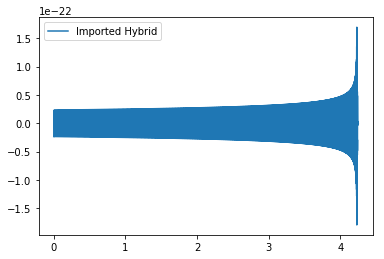

In [12]:
###Check to show it works
hybrid_path = path_name_data+hybrid_name ## path to hybrid in h5 format
hybrid_read = h5py.File(hybrid_path, 'r')
for item in hybrid_read.attrs.keys():
    print item + ":", hybrid_read.attrs[item]
hm1 = hybrid_read.attrs['grav_mass1']
hm2 = hybrid_read.attrs['grav_mass2']
hs1z = hybrid_read.attrs['spin1z']
hs1x = hybrid_read.attrs['spin1x']
hs1y = hybrid_read.attrs['spin1y']
hs2z = hybrid_read.attrs['spin2z']
hs2x = hybrid_read.attrs['spin2x']
hs2y = hybrid_read.attrs['spin2y']
hdistance = 1.0
hinclination = 0.0
### The starting frequency can sometimes give an input parameters error. This is usually due to pycbc rounding. Just 
### increase the starting frequency by 1.0 or something to fix it.
f_lowh = hybrid_read.attrs['f_lower_at_1MSUN'] + 2.0 
hybrid_read.close()
hhp,hhc = get_td_waveform(approximant='NR_hdf5',numrel_data=hybrid_path,mass1=hm1,
                                                                      mass2=hm2,
                                                                      spin1z=hs1z,spin1x=hs1x,spin1y=hs1y,
                                                                      spin2z=hs2z,spin2x=hs2x,spin2y=hs2y,
                                                                      delta_t=delta_t,distance=hdistance,
                                                                      f_lower=f_lowh,
                                                                      inclination=hinclination)
#plt.figure(figsize=(9,6), dpi =100)
plt.plot(hhp.sample_times,hhp,label='Imported Hybrid')
plt.legend()
plt.show()